In [1]:
%load_ext autoreload
%autoreload 2

import pyrtools as pt
import matplotlib.pyplot as plt
import numpy as np
import scipy
import utils

%matplotlib inline

In [2]:
import matplotlib

Outline:
1. Fourier space
2. Pyramids
3. Steerable pyramid

Really big important idea, this is the main frame to put things in: the point of the steerable pyramid is to "perform a spectral decomposition", that is, to break up Fourier space / frequency space. It tells you how much "stuff" there is in an image for a given range of frequencies and orientations. For example, how much fine-scale vertical stuff is there, vs. how much fine-scale horizontal stuff vs. coarse-scale vertical stuff. And it does this in a localized manner -- not just in the whole image, but for patches across the image.

For vision scientists, it makes a pretty good base model of V1, which I'll return to later

# Fourier space

So let's remind ourselves what Fourier space is

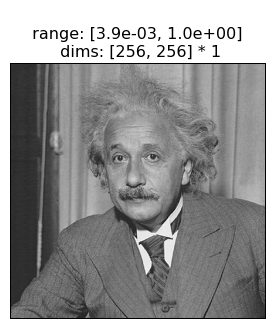

In [3]:
img = plt.imread('data/Einstein.pgm') / 255
pt.imshow(img);
fft = np.fft.fftshift(np.fft.fft2(img))

FFT of an image is complex-valued and same shape as the image.

In [45]:
fft

array([[-0.22352941+0.00000000e+00j, -2.25011526+2.56806269e+00j,
        -1.71784108-1.92963557e+00j, ...,  0.31752643+1.32794908e+00j,
        -1.71784108+1.92963557e+00j, -2.25011526-2.56806269e+00j],
       [-1.81509774-1.21295912e+00j, -1.86762132+9.53090330e-01j,
         0.65304235-1.71446771e-01j, ..., -2.40952936+4.95386731e-01j,
        -0.80664212+8.04943057e-01j, -0.14721   -9.78234288e-01j],
       [-1.31069153-1.18636127e+00j, -1.65747987-2.76053281e+00j,
        -0.72190774+4.60091323e+00j, ...,  1.39945352-4.28985487e+00j,
         1.86448923+4.24973171e-03j, -0.05173973+5.19862717e+00j],
       ...,
       [-2.00639991+1.04354978e+00j,  2.50079964-1.63907389e-01j,
         1.86559189-1.50221340e-01j, ...,  2.1716906 -1.10485944e+00j,
        -1.2349135 +1.69478942e+00j,  1.42858701-3.40180249e+00j],
       [-1.31069153+1.18636127e+00j, -0.05173973-5.19862717e+00j,
         1.86448923-4.24973171e-03j, ..., -1.03779142+9.47616854e-01j,
        -0.72190774-4.60091323e+00j

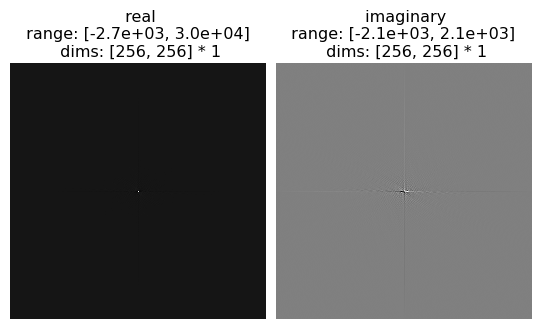

In [4]:
pt.imshow(fft);

If you recall, the real and imaginary components aren't that informative. what we typically want to do is look at them in their polar representation: the amplitude (also called power) and phase.

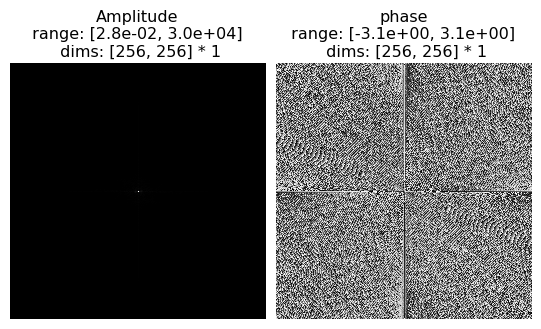

In [5]:
amp = np.abs(fft)
phase = np.angle(fft)

pt.imshow([amp, phase], title=['Amplitude', 'phase']);

All we can see in the amplitude image is a dot in the center -- this image, like all images of natural scenes, follows a 1/f energy distribution and has a large DC term, which swamps the other terms. Therefore, it's most useful to log at the log amplitude (we add the 1 to avoid taking the log of zero, which is negative infinity):

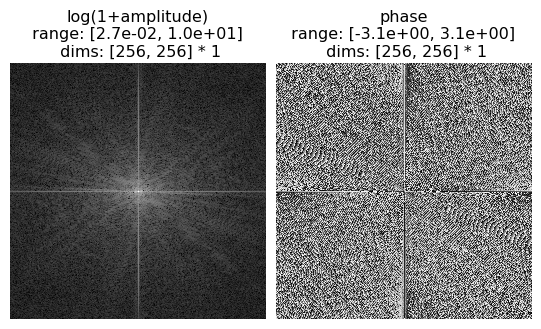

In [6]:
pt.imshow([np.log(1+amp), phase], title=['log(1+amplitude)', 'phase']);

(Note, This view is so useful that we have a convenience function for it: `pt.imshow(fft, plot_complex='logpolar');`)

This amplitude plot is generally what we mean by Fourier space (phase is generally hard to understand, we often pay most attention to the amplitude): distance from the center gives us spatial frequency, so the origin is the DC or constant term, which is related to global mean of the image (if image was zero-meaned, it would be zero). Then the value at a given point represents the amplitude for that spatial frequency, and angle gives orientation.

So we can still see we have most of the power in DC term, looks like it might decrease a bit but that's hard to see here. most power at the cardinals. symmetric at 180 degrees (orientation of up = orientation of down), let's show more clearly:

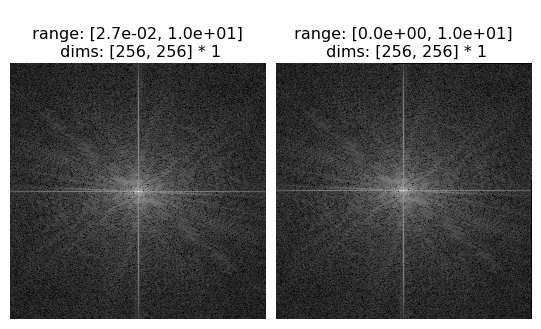

In [7]:
pt.imshow([np.log(1+amp), scipy.ndimage.rotate(np.log(1+amp), 180)]);

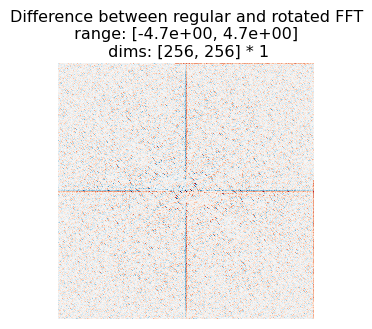

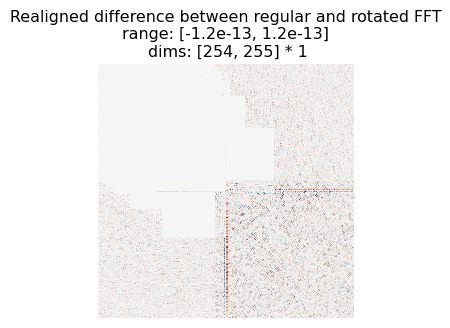

In [8]:
# optional

# If we just take the difference of these two, there's an alignment issue (owing to the fact the real power spectrum is rotationally symmetric, 
# but this discrete one is only approximately so). In the following, white is 0 and red and blue are negative and positive errors. We can see 
# issues at the axes, which is what tells us we're misaligned:

pt.imshow(np.log(1+amp) - scipy.ndimage.rotate(np.log(1+amp), 180), vrange='auto0', title="Difference between regular and rotated FFT");

# The following is approximately aligned (note that the range is -1e-13 to 1e-13)

pt.imshow(np.log(1+amp)[2:, 1:] - scipy.ndimage.rotate(np.log(1+amp), 180)[1:-1, :-1], vrange='auto0', title='Realigned difference between regular and rotated FFT');

That's all well and good, but it's hard to see if this power spectrum follows a 1/f distribution, so let's check that explicitly. We'll use a helper function, `amplitude_spectra`, which takes the amplitude of an image's 2d Fourier transform and then radially averages it:

/home/billbrod/miniconda3/envs/pyrtools/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


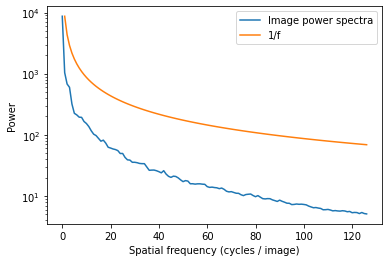

In [9]:
amp_spectra = utils.amplitude_spectra(img)
fig, ax = plt.subplots(1, 1)
ax.semilogy(amp_spectra, label='Image power spectra')
ax.semilogy(amp_spectra[0] * (1 / np.arange(len(amp_spectra))), label='1/f')
ax.set(ylabel='Power', xlabel="Spatial frequency (cycles / image)")
ax.legend()

That's not quite right, but we [know](https://en.wikipedia.org/wiki/Pink_noise) that 1/f generally means $1/f^\alpha$, for an $\alpha$ between 0 and 2 (and, for . Let's find a value that fits better:

/home/billbrod/miniconda3/envs/pyrtools/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


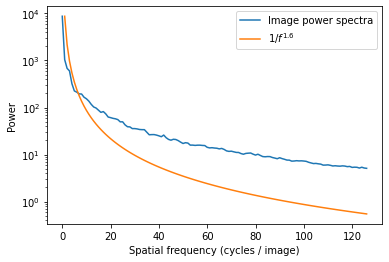

In [10]:
amp_spectra = utils.amplitude_spectra(img)
fig, ax = plt.subplots(1, 1)
ax.semilogy(amp_spectra, label='Image power spectra')
ax.semilogy(amp_spectra[0] * (1 / np.arange(len(amp_spectra)))**2, label='$1/f^{1.6}$')
ax.set(ylabel='Power', xlabel="Spatial frequency (cycles / image)")
ax.legend()

Why 1/f? It means that there's the same amount of power in each octave (so from 1 to 2 cycles/image, 2 to 4 cycles/image, 4 to 8 cycles/image, etc). For 2d signals, this should be $1/f^2$ in order to match this property, but we don't quite match it here. Might be because this is a headshot, which doesn't have quite the same stats as most natural images (and in particular, this has more power at high frequencies than matched $1/f^2$ would).

Okay, so: the Fourier transform gives us an alternative representation of an image (or any signal). It's completely equivalent to the original and, via the IFFT, we can go back and forth between the two. We often talk about the "spectral energy" or just "energy", which is the square of the amplitude or, equivalently, squaring and summing the real and imaginary parts. This is because the amplitude is the absolute value of a complex number, which is equal to its modulus: for complex-valued $a+bi$, the modulus is $\sqrt{a^2+b^2}$. The energy is thus that squared: $a^2+b^2$ (we'll come back to this point later). It is useful to be able to think about Fourier space for what we're about to do.

# Pyramids

## Filters

Pyramids are just nice ways of representing filters, so we'll start with filters and convolution:

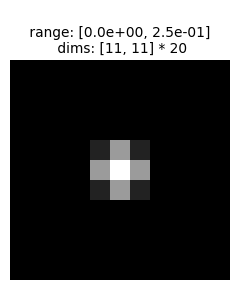

In [11]:
# small Gaussian filter
def gauss(size, std):
    x = np.arange(size) - size//2
    x = np.sum(np.square(np.meshgrid(x, x)), 0)
    gauss = np.exp(-x**2/(2*std**2))
    return gauss / gauss.sum()

filt = gauss(11, 1)
pt.imshow(filt, zoom=20);

I'm not going to step through convolutions in detail, but the idea is you multiply the filter defined above by another signal at every location in that second signal.

We can convolve this simple Gaussian filter to get a slightly blurred version of the image:

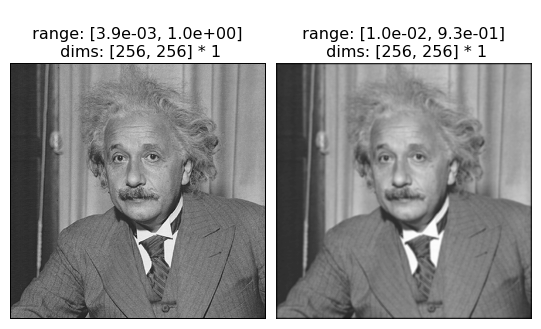

In [12]:
pt.imshow([img, scipy.ndimage.convolve(img, filt)]);

If we were to increase the standard deviation of our filter, we'd see an increasingly blurred version of the image:

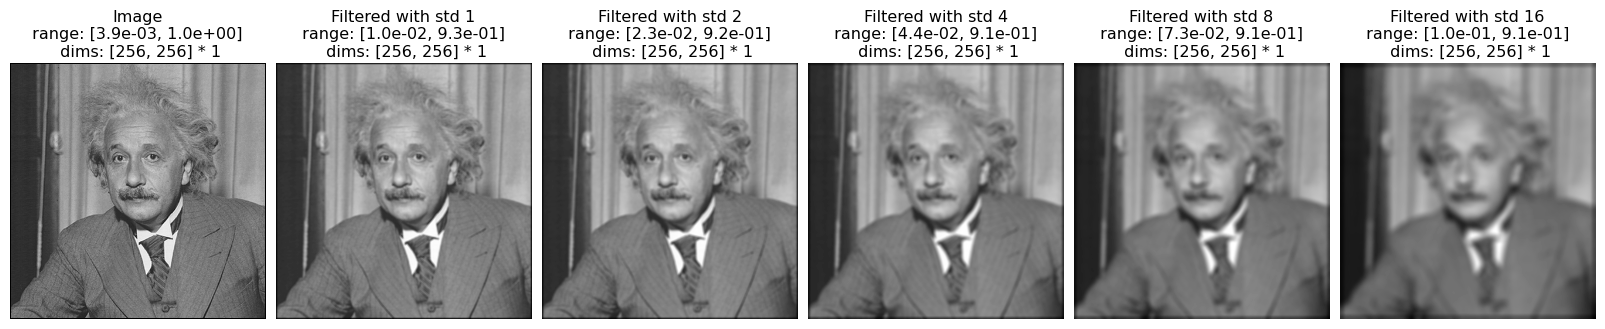

In [13]:
stds = [1, 2, 4, 8, 16]
pt.imshow([img] + [scipy.ndimage.convolve(img, gauss(11, i)) for i in stds], title=["Image"] + [f'Filtered with std {i}' for i in stds]);

So what's going on here? We can get a better sense by going back to Fourier space

In [14]:
# first let's right a little helper function:
def fourier_amp(img):
    return np.abs(np.fft.fftshift(np.fft.fft2(img)))

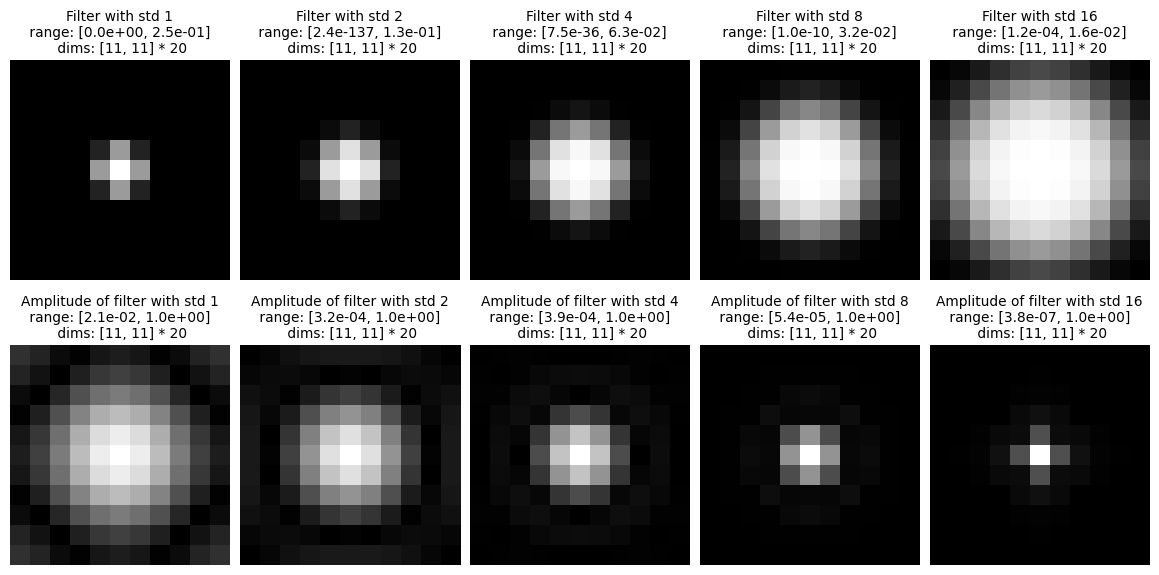

In [15]:
filts = [gauss(11, i) for i in stds]
pt.imshow(filts + [np.abs(fourier_amp(f)) for f in filts], zoom=20, col_wrap=len(filts), 
          title=[f'Filter with std {i}' for i in stds] + [f'Amplitude of filter with std {i}' for i in stds]);

The top row shows the Gaussians with increasing standard deviations. They get larger, as we'd expect. The bottom shows the amplitude of their Fourier transform: they get progressively *smaller*. Why? Gaussians are lowpass filters -- they remove high frequencies and preserve low frequencies. If you remember, spatial frequency is the distance from the origin of frequency space, so that's what we're seeing below (Gaussians also have the nice property where they're Fourier transform is also a Gaussian): as a Gaussian gets larger, it throws away higher and higher frequencies, so its Fourier transform gets smaller and smaller.

We can confirm this by looking at the amplitudes of our filtered images:

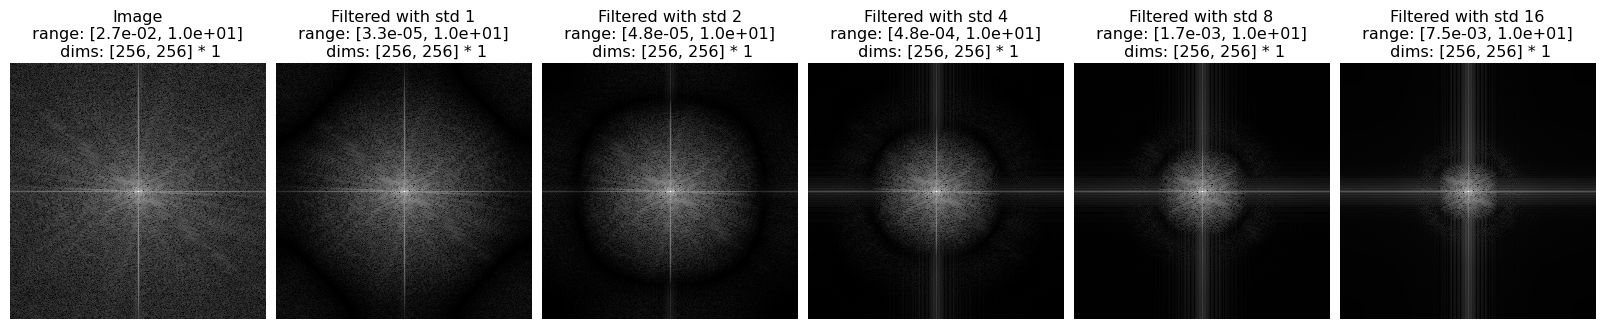

In [16]:
pt.imshow([np.log(1+fourier_amp(img))] + [np.log(1+fourier_amp(scipy.ndimage.convolve(img, f))) for f in filts],
          title=["Image"] + [f'Filtered with std {i}' for i in stds], );

So two things: first, the region that contains non-zero values shrinks as the filter gets larger, i.e., more and more of the high frequency info is being thrown away. Second, there's something weird going on, our filter is not perfectly lowpass. I'm pretty sure this is because constructing a good filter is hard and so we're seeing artifacts that result from that. In particular, using such a discretized Gaussian results in some weirdness (setting `vrange='indep0'` in the block showing the filters and their Fourier transform might make this more obvious)

But, main point: this demonstrates that looking at the Fourier representation of a filter is very useful. Why is that?

If you remember from math tools, a convolution in the signal domain is the same as multiplication in the Fourier domain. And multiplication is often easier to reason about. We can see this directly:

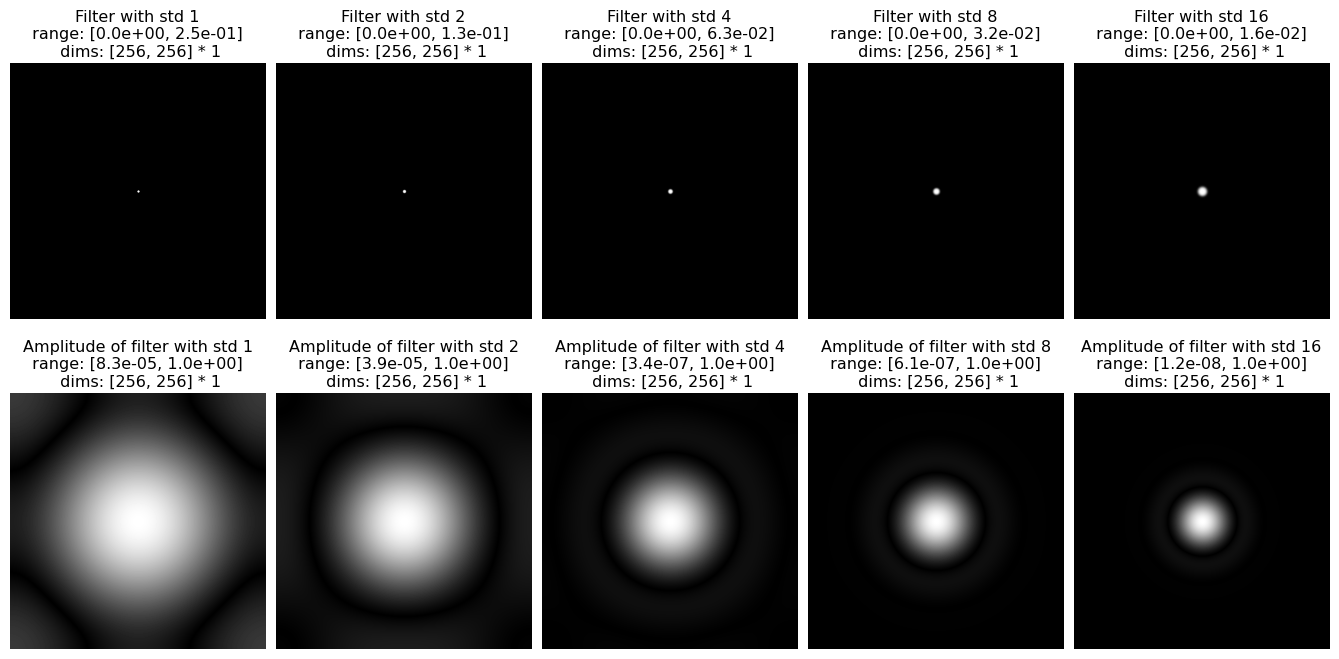

In [17]:
filts = [gauss(256, i) for i in stds]
fourier_filts = [fourier_amp(f) for f in filts]

# looks like just a better-sampled version of earlier
pt.imshow(filts + fourier_filts, zoom=1, col_wrap=len(filts), 
          title=[f'Filter with std {i}' for i in stds] + [f'Amplitude of filter with std {i}' for i in stds]);

In [18]:
img_fft = fourier_amp(img)
fourier_img = [f*img_fft for f in fourier_filts]

We can see the following looks very similar to earlier (though more circular).

We can't just take the IFFT here to get the image back because we've only held onto the amplitude, throwing out the necessary info for a reconstruction.

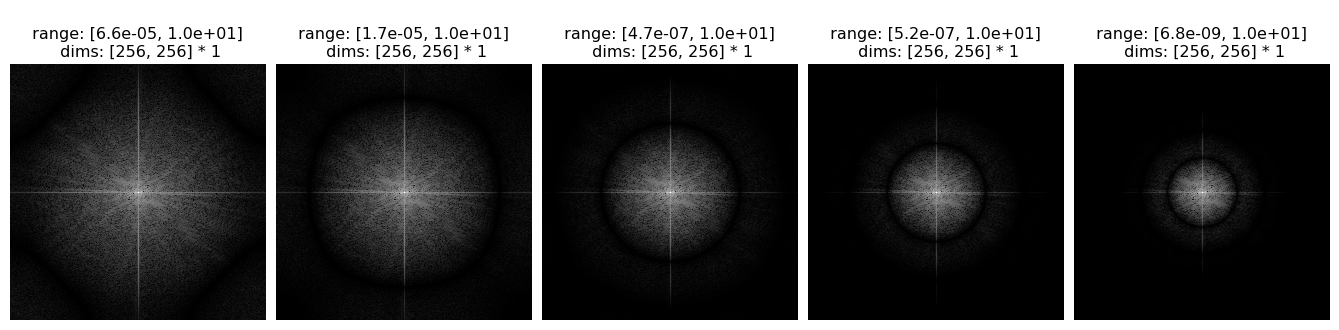

In [19]:
pt.imshow([np.log(1+f) for f in fourier_img]);

Two advantages here: much faster and more exact (we can see by its circularity and reduced artifacts). We'll come back to this later.

So what does all this have to do with pyramids? Well, it's often useful to get a multi-scale representation of an image. That is, we want to chunk frequency space into different bands and construct filters that are selective for those bands of frequency space.

Pyramids just implement this idea in octave steps. that is, each scale goes out to half the max of the previous scale. So if your first scale goes up to 128 cycles / image (that's the edge of the one above), then your next scale will go to 64, then 32, etc. I tried to do the above, but progressively doubling the std dev doesn't do that and it would take a bit to look into why.

They do it this way because they downsample by powers of 2. Let's see what that looks like:

The pyramids that we have in `pyrtools` all have a similar structure: they're all under `pt.pyramids`, they accept `image` as their first argument, they'll have a `height` argument that says how many times to downsample / how many scales to build, and some additional arguments:

In [20]:
pt.pyramids.GaussianPyramid?

Init signature:
pt.pyramids.GaussianPyramid(
    image,
    height='auto',
    filter_name='binom5',
    edge_type='reflect1',
    **kwargs,
)
Docstring:     
Gaussian pyramid

Parameters
----------
image : `array_like`
    1d or 2d image upon which to construct to the pyramid.
height : 'auto' or `int`.
    The height of the pyramid. If 'auto', will automatically determine based on the size of
    `image`.
filter_name : {'binomN', 'haar', 'qmf8', 'qmf12', 'qmf16', 'daub2', 'daub3', 'daub4', 'qmf5',
               'qmf9', 'qmf13'}
    name of filter to use when constructing pyramid. All scaled so L-2 norm is 1.0

    * `'binomN'` - binomial coefficient filter of order N-1
    * `'haar'` - Haar wavelet
    * `'qmf8'`, `'qmf12'`, `'qmf16'` - Symmetric Quadrature Mirror Filters [1]_
    * `'daub2'`, `'daub3'`, `'daub4'` - Daubechies wavelet [2]_
    * `'qmf5'`, `'qmf9'`, `'qmf13'`   - Symmetric Quadrature Mirror Filters [3]_, [4]_
edge_type : {'circular', 'reflect1', 'reflect2', 'repeat', 

Let's create a Gaussian pyramid now. Note that one of these arguments is `filter_name`, so the Gaussian pyramid here doesn't actually use Gaussian filters; it uses other lowpass filters

In [21]:
pyr = pt.pyramids.GaussianPyramid(img, filter_name='binom11', height=5)

This is a python object, which has a variety of attributes. The most important for us is `pyr_coeffs`, a dictionary with the pyramid coefficients, i.e., the output of the filtering. It has a set of `(scale, band)` keys (gaussian pyramid only has one band, but the steerable has more than one and this allows us to be consistent):

In [22]:
pyr.pyr_coeffs.keys()

dict_keys([(0, 0), (1, 0), (2, 0), (3, 0), (4, 0)])

Let's look at them:

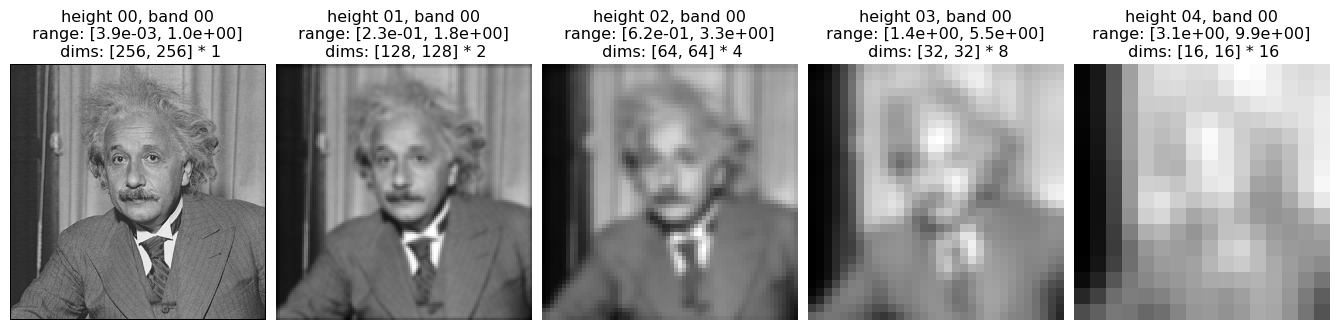

In [23]:
pt.pyrshow(pyr.pyr_coeffs);

We can see again that these are progressively downsampled versions of the image. Note that the resolution is decreasing for each of these (just up-sampled for display purposes) and that the resolution decreases by 2 at each step. It's lowpass, like before.

Why downsampling? It's easier computationally: it allows you to use the same filter for each scale. You convolve the filter with the image, then you downsample the image and convolve the filter again. Since you've downsampled, you've halved the frequencies of everything in the image, effectively changing the size of your filter. In order to do this, you have to also use an anti-aliasing filter so you throw away any information that's high frequency enough in the original image that it would alias in the downsampled version. This is smoothing and downsampling is called "pyramid reduce" and is the proper way to downsample an image in order to avoid artifacts.

Each of these coefficients is a real-valued array, which you can treat the way you normally would:

In [24]:
pyr.pyr_coeffs[(0, 0)]

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.19607843, 0.19607843, ..., 0.60392157, 0.61568627,
        0.00392157],
       [0.00392157, 0.20784314, 0.20784314, ..., 0.60392157, 0.60392157,
        0.00392157],
       ...,
       [0.00392157, 0.45490196, 0.49019608, ..., 0.18823529, 0.18039216,
        0.00392157],
       [0.00392157, 0.45490196, 0.42352941, ..., 0.17254902, 0.19215686,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157]])

We can similarly look at our filter. We can see it looks like vaguely Gaussian-like

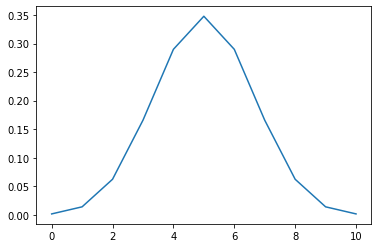

In [25]:
plt.plot(pyr.filters['downsample_filter'])

# Steerable pyramid

Now let's move onto steerable pyramid! What's special about it? Like I said, it breaks up Fourier space nicely and serves as a good base model for V1 receptive fields.

For the first point, let's look at a figure from Eero and Bill Freeman's paper defining the steerable pyramid:

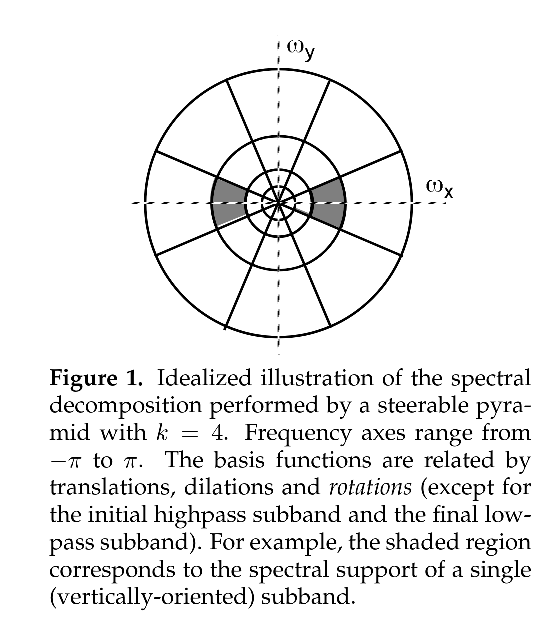

In [26]:
pt.imshow(plt.imread('data/Simoncelli95_fig1.png'), title=None, zoom=.5);

This was their goal. To design a set of filters that carved of Fourier space so they could get bands of frequencies and orientations.

Several things to point out here:
1. Orientation is radially symmetric at 180 degrees, which is why they're highlighting both points along the diagonal.
2. We're doing the octave-spaced scales like before: the outer band is twice the radius of the highlighted one, which is twice the radius of the one within it, etc.
3. We're now *bandpass*, not *lowpass*. With lowpass, you take everything from the origin to your frequency limit. With bandpass, you want to ignore the center. This reduces redundant information (and, is nice for vision scientists, since V1 neurons are also generally bandpass)

So how do you get filters that do this? They used Gaussian directional derivatives:

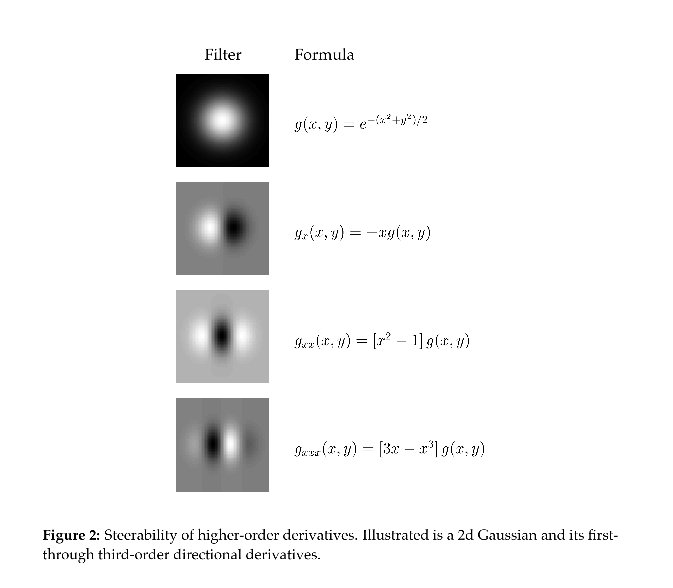

In [27]:
pt.imshow(plt.imread('data/Heeger98_fig2.png'), title=None, zoom=.5);

If you remember your calculus, you can take the directional derivative of a 2d function. that is, you can take its derivative with respect to x or with respect to y.

That's what they did here. At the top you have a Gaussian, then its first order derivative with respect to x. then they took the derivative of *that* with respect to x to get the second-order "xx" derivative. and similarly for the bottom. 

All of these, then are sensitive to fluctuations in the x direction (or, vertical bars): they'll be maximally driven by two (or more) vertical bars aligned with their excitatory subregion, and minimally by the horizontal one, which will activate both inhibitory and excitatory regions. So that's given us orientation selectivity!

They also could have taken the derivative with respect to y, to get the orthogonal direction. and instead of doing "xx", they could have done "xy" or "yx" to get diagonal. That might be a bit abstract, so let's see:

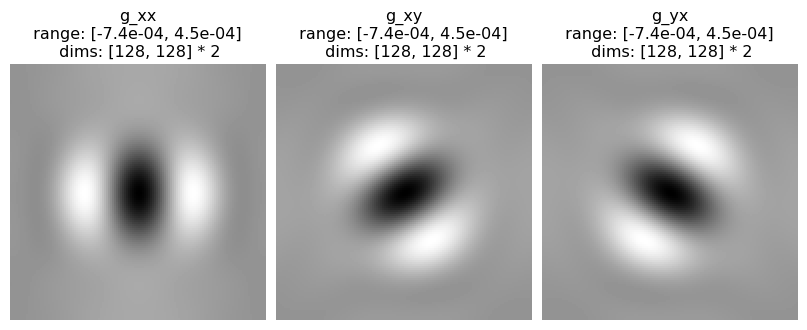

In [28]:
filts = utils.get_steerpyr_filters(128, order=2)
pt.imshow([filts[(4, i)] for i in range(3)], zoom=2, title=["g_xx", "g_xy", "g_yx"]);

"order", when talking about the steerable pyramid, refers to the order of the Gaussian derivative, which determines how many orientations you have (order+1)

Why no vertical? Because it's unnecessary, which we'll talk about in a bit

So that's cool, but let's look at the fourier representation:

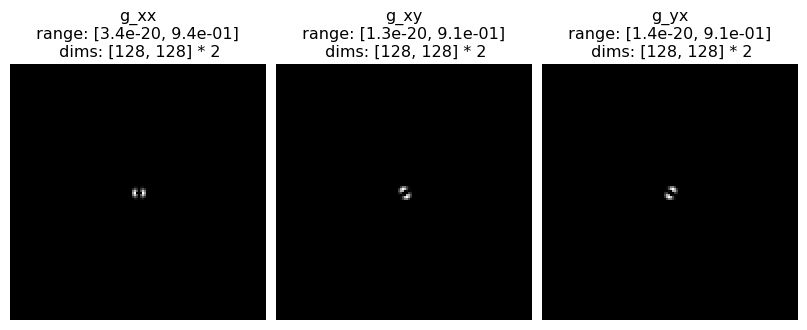

In [29]:
filts = utils.get_steerpyr_freq_filters(128, order=2)
pt.imshow([filts[(4, i)] for i in range(3)], zoom=2, title=["g_xx", "g_xy", "g_yx"]);

That's cool, but they're really small! Remember, size in spatial and freqeency domains are inveresely correlated: large filters means selectivity for high lower frequencies. To see more clearly, let's look at a different scale. First, the filters:

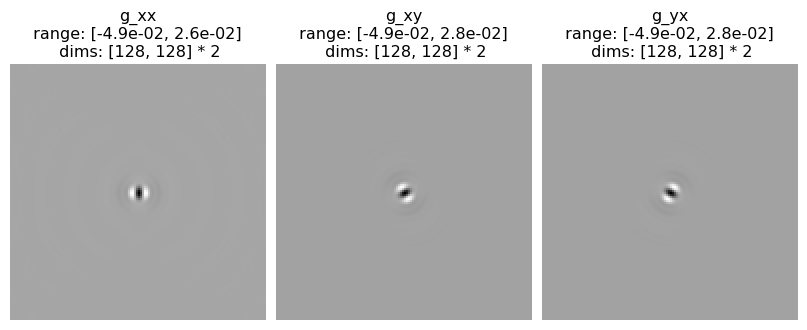

In [30]:
filts = utils.get_steerpyr_filters(128, order=2)
pt.imshow([filts[(1, i)] for i in range(3)], zoom=2, title=["g_xx", "g_xy", "g_yx"]);

Same as above, just smaller. Now the frequency representation:

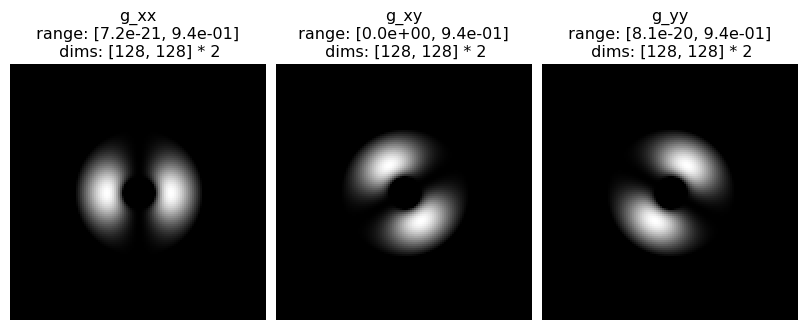

In [31]:
filts = utils.get_steerpyr_freq_filters(128, order=2)
pt.imshow([filts[(1, i)] for i in range(3)], zoom=2, title=["g_xx", "g_xy", "g_yy"]);

Much easier to see. 

We can see several things here:
1. we have a perfect annulus in frequency space. That means we're only selective for this range of frequencies and throw out all others, i.e., perfectly bandpass!
2. ramps up slower on the outside than on the inside
2. We have three orientations, they cover orientation space smoothly, and together they uniformly cover orientation space. that last is hard to see, but let's plot the sum across these orientations:

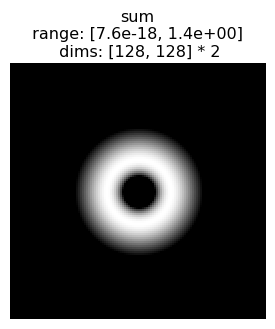

In [32]:
pt.imshow(np.sum([filts[(1, i)] for i in range(3)], 0), title='sum', zoom=2);

This nice smooth representation of orientation is one of the key benefits of steerable pyramids. They don't cover scales quite as smoothly:

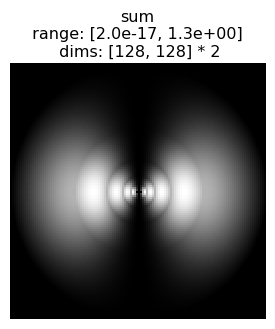

In [33]:
pt.imshow(np.sum([filts[(i, 0)] for i in range(5)], 0), title='sum', zoom=2);

Not nearly as nice.

Okay, so that's the filters, let's look at the pyramid! There are two implementations, space and frequency. Recall earlier when we talked about how a convolution in the spatial domain is the same as multiplication in the frequency domain. So they're equivalent. In general, we use the frequency domain one because: reconstruction is exact and it can produce any number of orientation bands, but its boundary-handling is circular. (in our notes we have that it's slower, but I think that depends on size of image and other factors)

In [34]:
pyr = pt.pyramids.SteerablePyramidFreq(img)

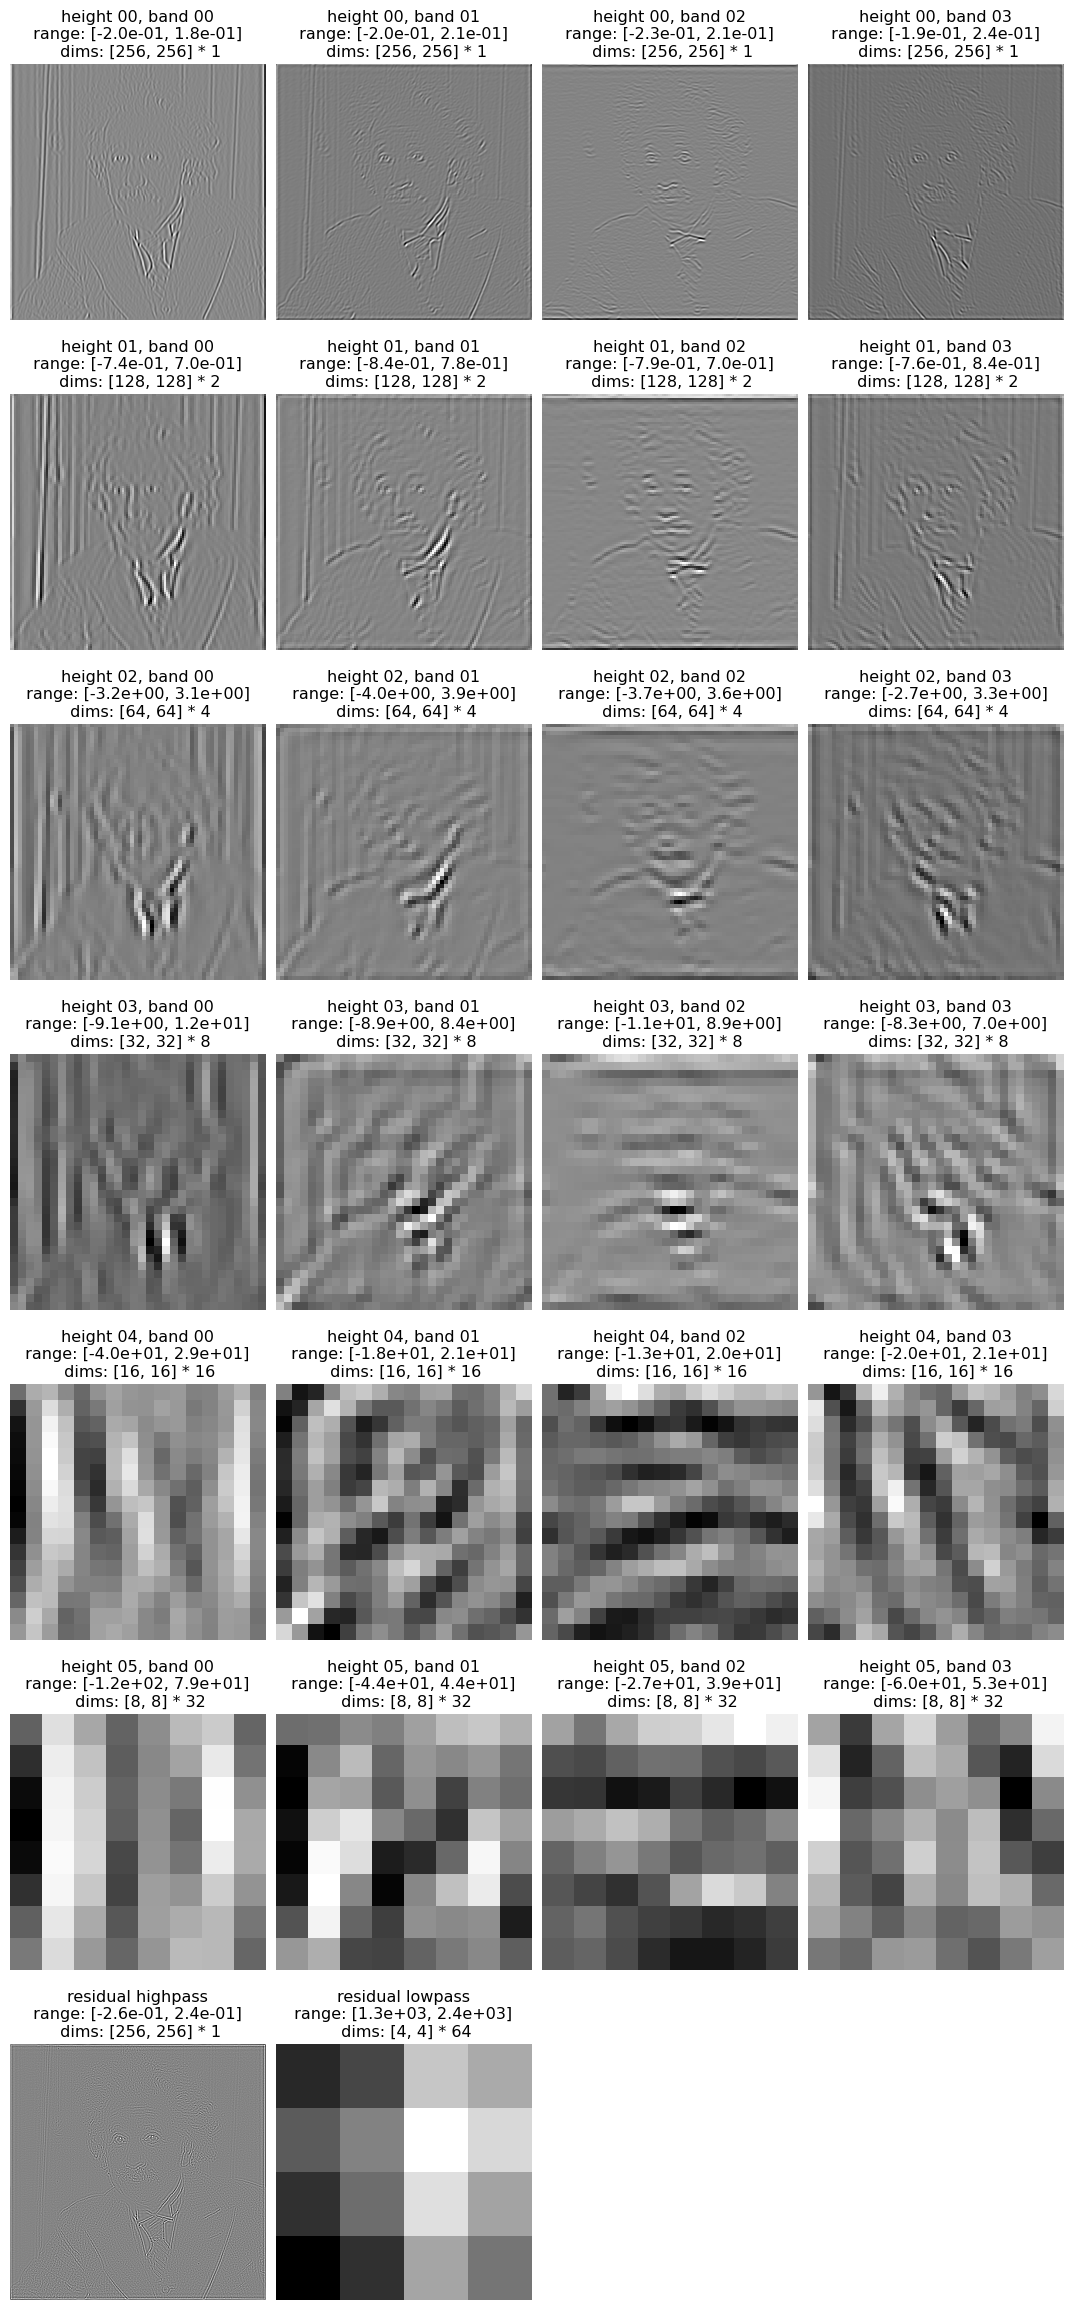

In [35]:
pt.pyrshow(pyr.pyr_coeffs);

Okay, now I've spent a lot of time looking at images like this. So let's talk about them. It's the output of the filters at each scale and orientation. We can see that band 0 is vertical, band 2 is horizontal, the others are the diagonals. As you go up, you get coarser. Note that we're plotting at the same resolution here, but the actual representations are being down-sampled.

What else? Unlike the earlier lowpass representations we saw, note how these are definitely don't look like blurred versions of the image and are all mean gray. That's because it's bandpass: we do not include the low frequency information, which includes the image mean.

Two things at the end here that might be confusing: residual highpass and residual lowpass. Let's return to Eero's figure:

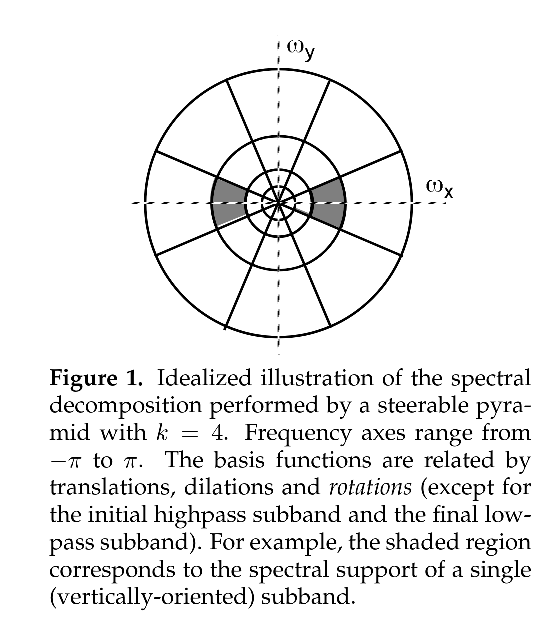

In [36]:
pt.imshow(plt.imread('data/Simoncelli95_fig1.png'), title=None, zoom=.5);

As we break up frequency space, there's a region outside the circle that is higher frequency than we care about and there will eventually be a region in the center that is lower frequency than we care about. Those are the residuals, and we typically ignore them.

What does this look like in Freuqency space? Let's remind ourselves of the image's Fourier transform:

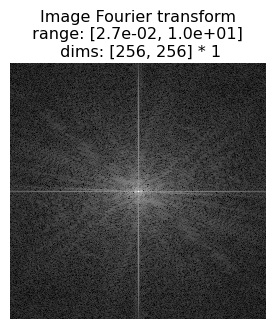

In [37]:
pt.imshow(np.log(1+fourier_amp(img)), title='Image Fourier transform');

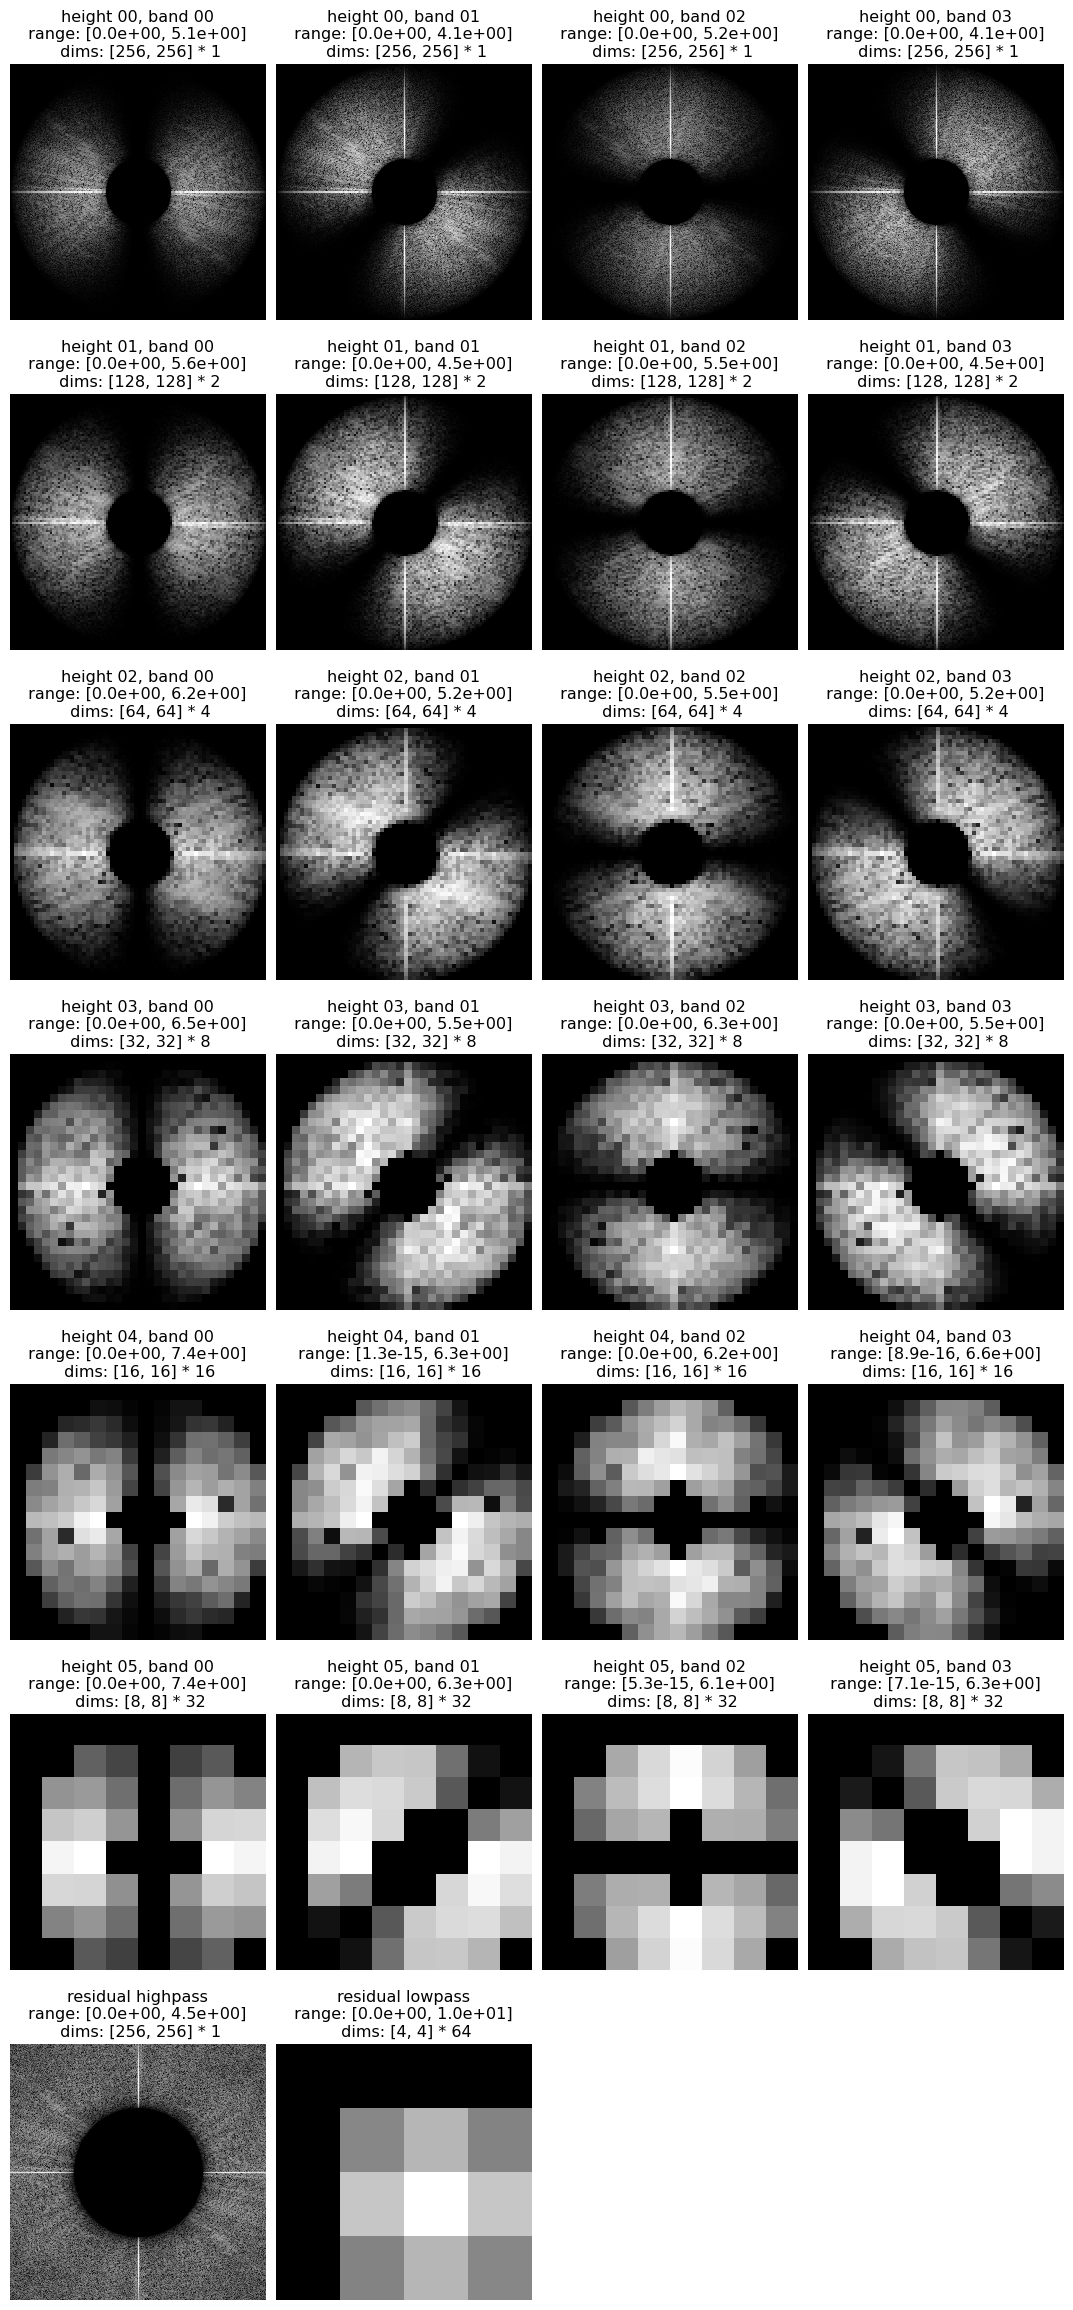

In [38]:
pt.pyrshow({k: np.log(1+fourier_amp(v)) for k, v in pyr.pyr_coeffs.items()});

We can see that it's basically the same thing on progressively down-sampled versions. If we were to upsample, they would fit within each other.

Couple more points: the pyramids are called "steerable" because you can linearly interpolate the outputs of the filters at a given set of orientations to get the output at *any* other orientation (this is called steerability). This isn't so useful for our purposes as vision scientists, but does allow you to make pretty movies:

In [39]:
num_orientations_steered = 120
steered_coeffs, steering_vectors = pyr.steer_coeffs([i*np.pi/180 for i in np.linspace(-180, 180, num_orientations_steered)])

steered_coeffs_dft = {}
for k, v in steered_coeffs.items():
    steered_coeffs_dft[k] = np.log(1+np.fft.fftshift(np.abs(np.fft.fft2(v, s=pyr.pyr_coeffs[(k[0], 0)].shape))))

Let's look in frequency space first. (this only works if you have ffmpeg on your computer)

In [40]:
pt.animshow(np.array([steered_coeffs_dft[(1, i)] for i in range(num_orientations_steered)]),
            framerate=12, repeat=True, zoom=4)

We can see it rotating smoothly around, highlighting whatever orientation we want. Similarly, though maybe a bit harder to see, in spatial domain:

In [41]:
pt.animshow(np.array([steered_coeffs[(1, i)] for i in range(num_orientations_steered)]), framerate=12, repeat=True, zoom=4)

What about energy? We also have the complex version of the pyramid implemented:

In [42]:
pyr = pt.pyramids.SteerablePyramidFreq(img, is_complex=True)
pyr.pyr_coeffs[(0, 0)]

array([[ 0.04808803-0.03826353j,  0.02504597+0.04011886j,
        -0.02538009+0.0188725j , ...,  0.04373277+0.02718798j,
        -0.03673984+0.05554044j, -0.05205229-0.04595539j],
       [ 0.09111537-0.08335252j,  0.0574591 +0.062534j  ,
        -0.02979836+0.03798679j, ...,  0.07445819+0.06033839j,
        -0.08639105+0.10149869j, -0.10325919-0.10031645j],
       [ 0.12568   -0.11602459j,  0.08135218+0.08305845j,
        -0.03546671+0.05262088j, ...,  0.09570967+0.08151007j,
        -0.11971702+0.13447288j, -0.14021631-0.13992844j],
       ...,
       [ 0.10714151-0.1095964j ,  0.09483345+0.10170965j,
        -0.07208527+0.06445859j, ...,  0.02784087+0.04093867j,
        -0.0638194 +0.06526235j, -0.09811892-0.09008575j],
       [ 0.07980801-0.07663897j,  0.06522819+0.07866784j,
        -0.05801691+0.04492341j, ...,  0.02662945+0.02755653j,
        -0.04320698+0.05171278j, -0.07158663-0.064072j  ],
       [ 0.044297  -0.03562576j,  0.02727092+0.04643431j,
        -0.03605078+0.0205806j

Now, each of the coefficients are complex-valued. This corresponds, because of something called the Hilbert transform that I don't really understand, to having two of those filters in quadrature phase, shifted by 90 degrees. Because of how things are implemented, I can't show you on the filters, but we can look at the outputs and see it:

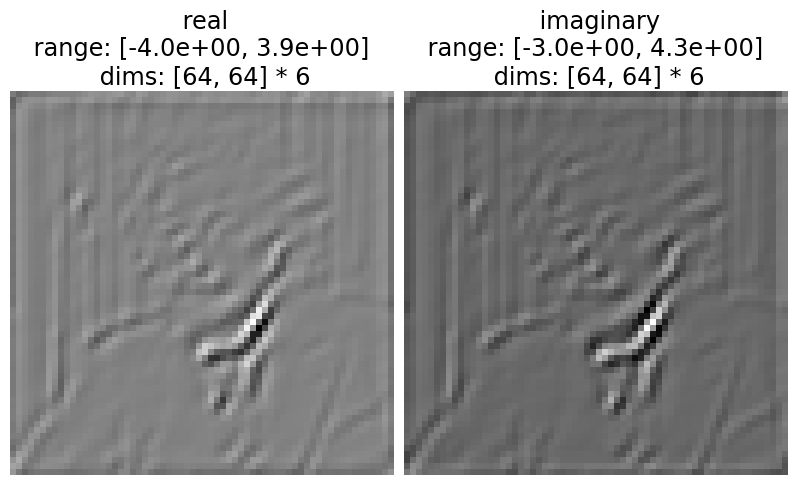

In [43]:
pt.imshow(pyr.pyr_coeffs[(2, 1)], zoom=6);

Einstein's neck here aligns with the preferred orientation of this filter, and we can see the phase of the real and imaginary components.

Now, since we have filters in quadrature pair, if we square and sum them, we get the energy:

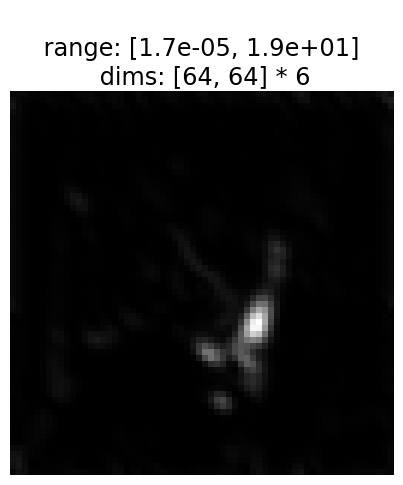

In [44]:
pt.imshow(np.abs(np.square(pyr.pyr_coeffs[(2, 1)])), zoom=6);

And this is the spectral energy at this scale and orientation. Unlike filter outputs, this has to be non-negative.

What does any of this have to do with vision science?

We often think of V1 cells as being oriented bandpass filters: they respond to a range of frequencies and orientations in a small patch of space. That's what steerable pyramids do! You could also use Gabors for this, but pyramids have some nice properties: tile the whole image, smoothly cover orientation space, efficient. They get this at the cost of simplifying some things (the size to scale ratio is fixed, unlike in Gabors).

Furthermore, simple cells are (by definition), phase-sensitive, whereas complex cells are not. The most common model for complex cells is the energy model (from [this Movshon paper](https://www.cns.nyu.edu/~tony/Publications/movshon-thompson-tolhurst-1978b.pdf)), which gets at this property by squaring and summing the outputs of simple cells, making complex cells' responses a measure of spectral energy. That's exactly what the energy computation above does! So, useful.

See README for further reading